In [1]:
from efficientnet_pytorch import EfficientNet
import torchvision.models as models
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
test_df = pd.read_csv("C:/Users/desktop-pc/Desktop/test.csv")

In [3]:
import torch.utils.data as data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, transform_b2=None, transform_b3=None):
        'Initialization'
        self.df = df
        self.transform_b2 = transform_b2
        self.transform_b3 = transform_b3

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['outcome_idx'][index]))

        if self.transform_b2:
            X_b2 = self.transform_b2(X)
            
        if self.transform_b3:
            X_b3 = self.transform_b3(X)

        return X_b2, X_b3, y

In [4]:
effNetb2 = torch.load('C:/Users/desktop-pc/Desktop/EfficientNet/EfficientNet-b2/EfficientNet-b2_gradients_best.pth')
effNetb3 = torch.load('C:/Users/desktop-pc/Desktop/EfficientNet/EfficientNet-b3/EfficientNet-b3_best_loss.pth')#net = torch.load("C:/Users/desktop-pc/Desktop/EfficientNet/EfficientNet-b2 - Accumulating Gradients/EfficientNet-b2_gradients_best.pth", map_location=torch.device('cpu'))  

In [5]:
import torchvision.transforms as trf
# defining the transformation of the images.

composed_b2 = trf.Compose([trf.Resize((260,260)), trf.ToTensor(),
                        trf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

composed_b3 = trf.Compose([trf.Resize((300,300)), trf.ToTensor(),
                        trf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


test_set = Dataset(test_df, transform_b2=composed_b2, transform_b3=composed_b3)
test_generator = data.SequentialSampler(test_set)

In [ ]:
## Averaging the crossentropy outcomes ##
'''from PIL import Image

device='cuda:0'

effNetb2.eval()
effNetb3.eval()
y_pred = []
y_true = []
softmax = torch.nn.Softmax(dim=1)
for i in test_generator:
    data_sample_b2, data_sample_b3, y = test_set.__getitem__(i)
    data_b2_gpu, data_b3_gpu = data_sample_b2.unsqueeze(0).to(device), data_sample_b3.unsqueeze(0).to(device) ##################
    output_b2, output_b3 = effNetb2(data_b2_gpu), effNetb3(data_b3_gpu)
    avg_predictions = output_b2.add(output_b3) / 2
    result = torch.argmax(avg_predictions)
    y_pred.append(result.item())
    y_true.append(y.item())

correct_results = np.array(y_pred)==np.array(y_true)
sum_correct = np.sum(correct_results)
accuracy = sum_correct/test_generator.__len__()'''

In [6]:
from PIL import Image

device='cuda:0'

'''Evaluating on test set'''
effNetb2.eval()
effNetb3.eval()
y_pred = []
y_true = []
softmax = torch.nn.Softmax(dim=1)
for i in test_generator:
    data_sample_b2, data_sample_b3, y = test_set.__getitem__(i)
    data_b2_gpu, data_b3_gpu = data_sample_b2.unsqueeze(0).to(device), data_sample_b3.unsqueeze(0).to(device) ##################
    output_b2, output_b3 = effNetb2(data_b2_gpu), effNetb3(data_b3_gpu)
    probabilities_b2 = softmax(output_b2)[0].cpu().detach().numpy()
    probabilities_b3 = softmax(output_b3)[0].cpu().detach().numpy()
    probabilities_ensembler = (probabilities_b2 + probabilities_b3) / 2
    result = np.argmax(probabilities_ensembler)
    y_pred.append(result.item())
    y_true.append(y.item())

correct_results = np.array(y_pred)==np.array(y_true)
sum_correct = np.sum(correct_results)
accuracy = sum_correct/test_generator.__len__()

In [7]:
from sklearn.metrics import balanced_accuracy_score, recall_score, classification_report, confusion_matrix

# Accuracy, Balanced Accuracy and Recall Scores
balanced_acc = balanced_accuracy_score(y_true, y_pred)
recall_score_macro = recall_score(y_true, y_pred, average='macro') 
recall_score_micro = recall_score(y_true, y_pred, average='micro')
recall_score = recall_score(y_true, y_pred, average=None) 

print("Accuracy ", accuracy)
print("Balanced Accuracy ", balanced_acc)
print("Recall Score macro ", recall_score_macro)
print("Recall Score micro ", recall_score_micro)
print("Recall Score for each class ", recall_score)

Accuracy  0.8162620880205249
Balanced Accuracy  0.8172090443118704
Recall Score macro  0.8172090443118704
Recall Score micro  0.8162620880205249
Recall Score for each class  [0.7393617  0.8870229  0.73244782 0.74145299 0.84871287 0.96363636
 0.90196078 0.72307692]


In [8]:
target_names = ['AK actinic keratosis', 'BCC basal cell carcinoma', 'BKL benign keratosis', 'MEL melanoma', 'NV Melanocytic nevi', 'VASC vascular lesion', 'DF dermatofibroma ', 'SCC Squamous cell carcinoma']
print(classification_report(y_true, y_pred, target_names=target_names))

                             precision    recall  f1-score   support

       AK actinic keratosis       0.59      0.74      0.66       188
   BCC basal cell carcinoma       0.81      0.89      0.85       655
       BKL benign keratosis       0.72      0.73      0.73       527
               MEL melanoma       0.72      0.74      0.73       936
        NV Melanocytic nevi       0.92      0.85      0.88      2525
       VASC vascular lesion       0.80      0.96      0.88        55
         DF dermatofibroma        0.60      0.90      0.72        51
SCC Squamous cell carcinoma       0.66      0.72      0.69       130

                   accuracy                           0.82      5067
                  macro avg       0.73      0.82      0.77      5067
               weighted avg       0.82      0.82      0.82      5067



In [9]:
# https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
cnf_matrix = confusion_matrix(y_true, y_pred)
print(cnf_matrix)

[[ 139   18   16    2    1    0    1   11]
 [  20  581    6   15    9    3    2   19]
 [  31   22  386   34   43    0    3    8]
 [  18   30   40  694  136    1    9    8]
 [  15   49   77  215 2143    9   15    2]
 [   0    1    0    1    0   53    0    0]
 [   1    2    1    0    0    0   46    1]
 [  10   13    8    4    0    0    1   94]]


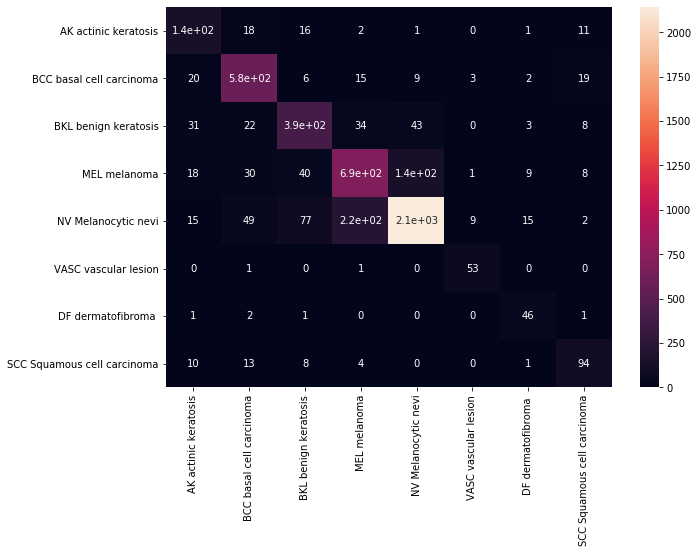

In [10]:
import seaborn as sn
# Ploting the Confusion Matrix
df_cm = pd.DataFrame(cnf_matrix, index = target_names, columns = target_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [11]:
lesion_type_dict = {0:'AK actinic keratosis', 1:'BCC basal cell carcinoma', 2:'BKL benign keratosis', 3: 'MEL melanoma', 4: 'NV Melanocytic nevi', 5: 'VASC vascular lesion', 6: 'DF dermatofibroma ', 7: 'SCC Squamous cell carcinoma'}
for condition in range(8):
    print(lesion_type_dict[condition])

AK actinic keratosis
BCC basal cell carcinoma
BKL benign keratosis
MEL melanoma
NV Melanocytic nevi
VASC vascular lesion
DF dermatofibroma 
SCC Squamous cell carcinoma


In [12]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
# Multiclass Roc-AUC Score
multiclass_roc_auc_score(y_true, y_pred)

0.89352200977258